# Identify Customer Churn in Telecom Data: Standard Machine Learning

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

# Scoring
from sklearn import metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score

### Import data

In [90]:
# Store data in dataframe 'df'
df = pd.read_csv("Telecom_customer_churn.csv")

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

<AxesSubplot:ylabel='churn'>

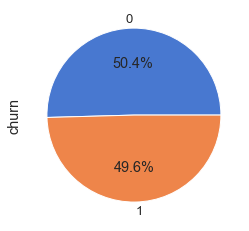

In [110]:
# Look at Target balance
sns.set(rc={'figure.figsize':(8,4)})
sns.set(font_scale=1.2, palette="muted")
df['churn'].value_counts().plot.pie(autopct='%1.1f%%')

In [111]:
df['Customer_ID'].nunique()

100000

<AxesSubplot:xlabel='months'>

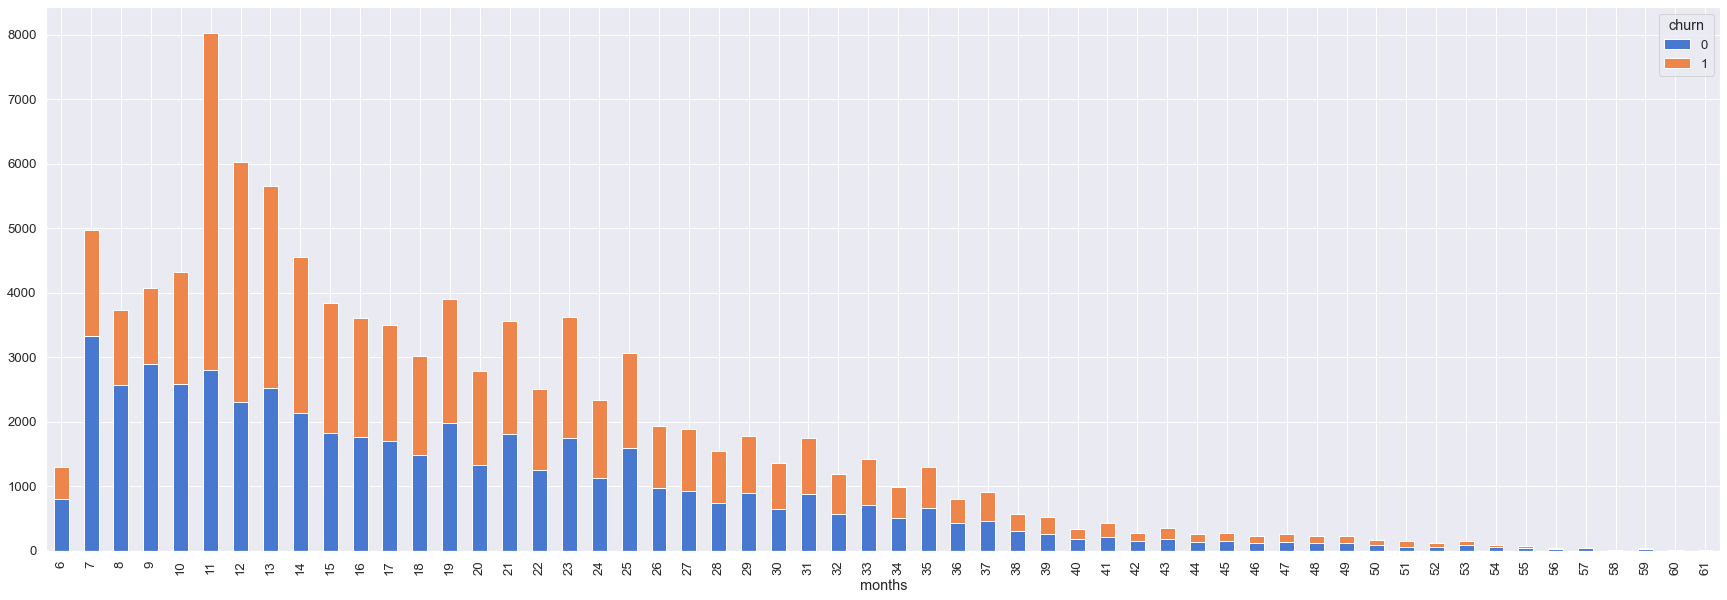

In [115]:
df.groupby(["months", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))

array([[<AxesSubplot:title={'center':'eqpdays'}>,
        <AxesSubplot:title={'center':'totmrc_Mean'}>]], dtype=object)

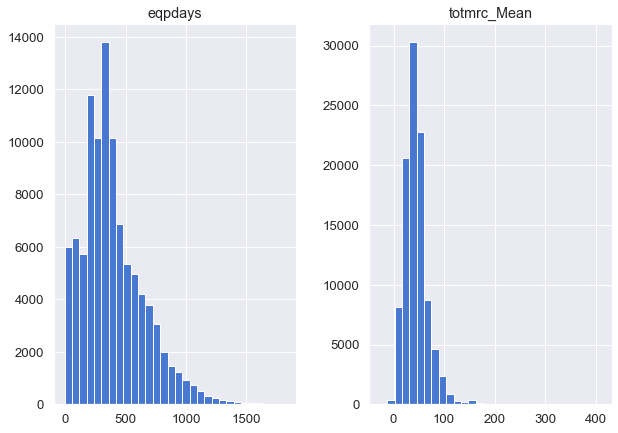

In [118]:
# Plot features of interest
imp_features = [ "eqpdays", "totmrc_Mean"]
plotting = df[imp_features]
df[imp_features].hist(bins=30, figsize=(10, 7))

### Clean

#### Previous analysis determined categorical data can be removed for our purposes.

In [22]:
# From EDA we know the 'object' type data appeared to have little correlation if any and 
# contained the majority of NaN's.  Therefore these were dropped during our test.
#. Note, earlier tests using this data did not improve results compared to PyCaret

df = df.select_dtypes(exclude='object')

### Remove multicollinear columns

In [93]:
cor_matrix = df.corr().abs()

In [24]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

<ipython-input-24-0cb03552b6b1>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [25]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

In [29]:
df = df.drop(columns = to_drop, axis=1)

<AxesSubplot:>

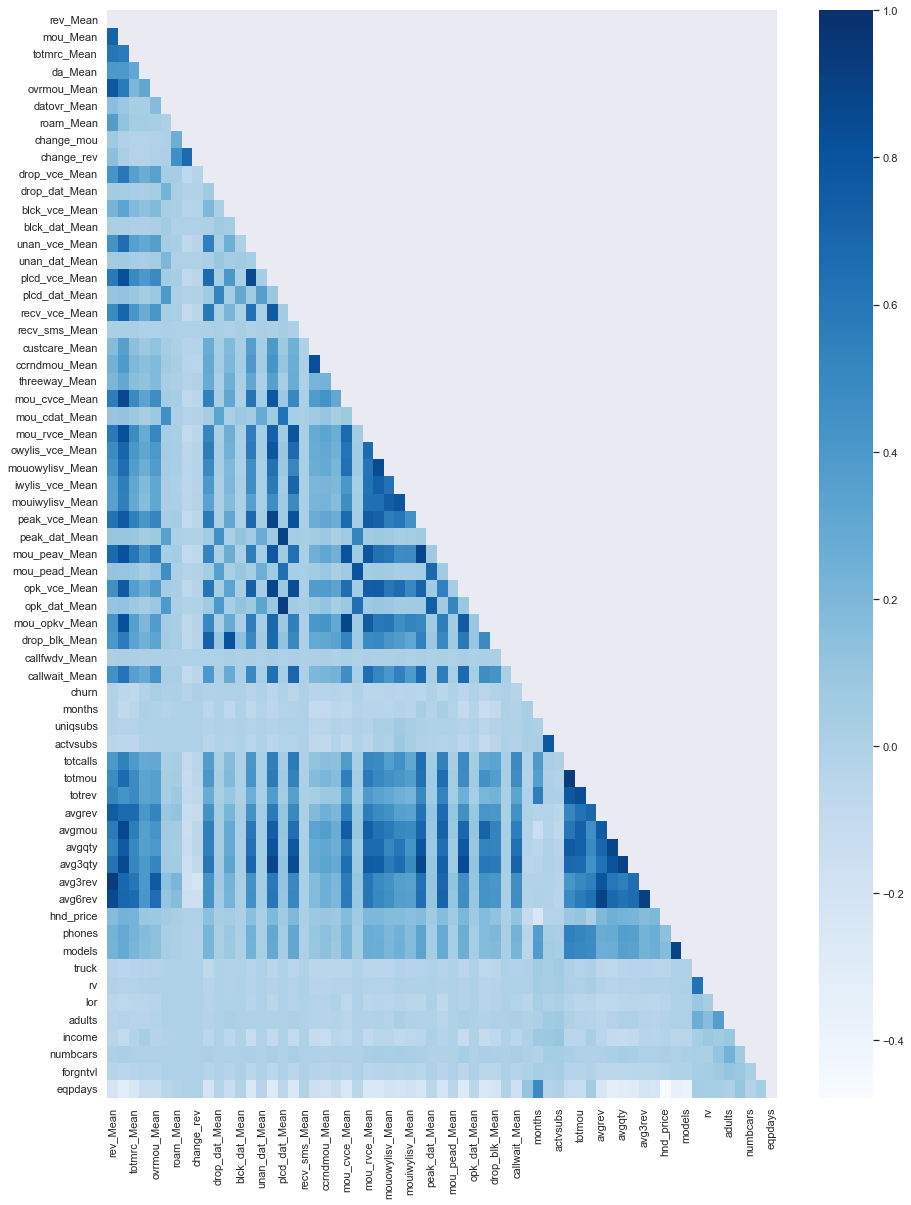

In [30]:
corr = df.corr()
matrix = np.triu(corr)
sns.set(rc={'figure.figsize':(15,20)})
sns.heatmap(df.corr(), cmap="Blues", vmax=1.0, mask=matrix)

### Compare Target correlation to features: Pearson's Coeficient

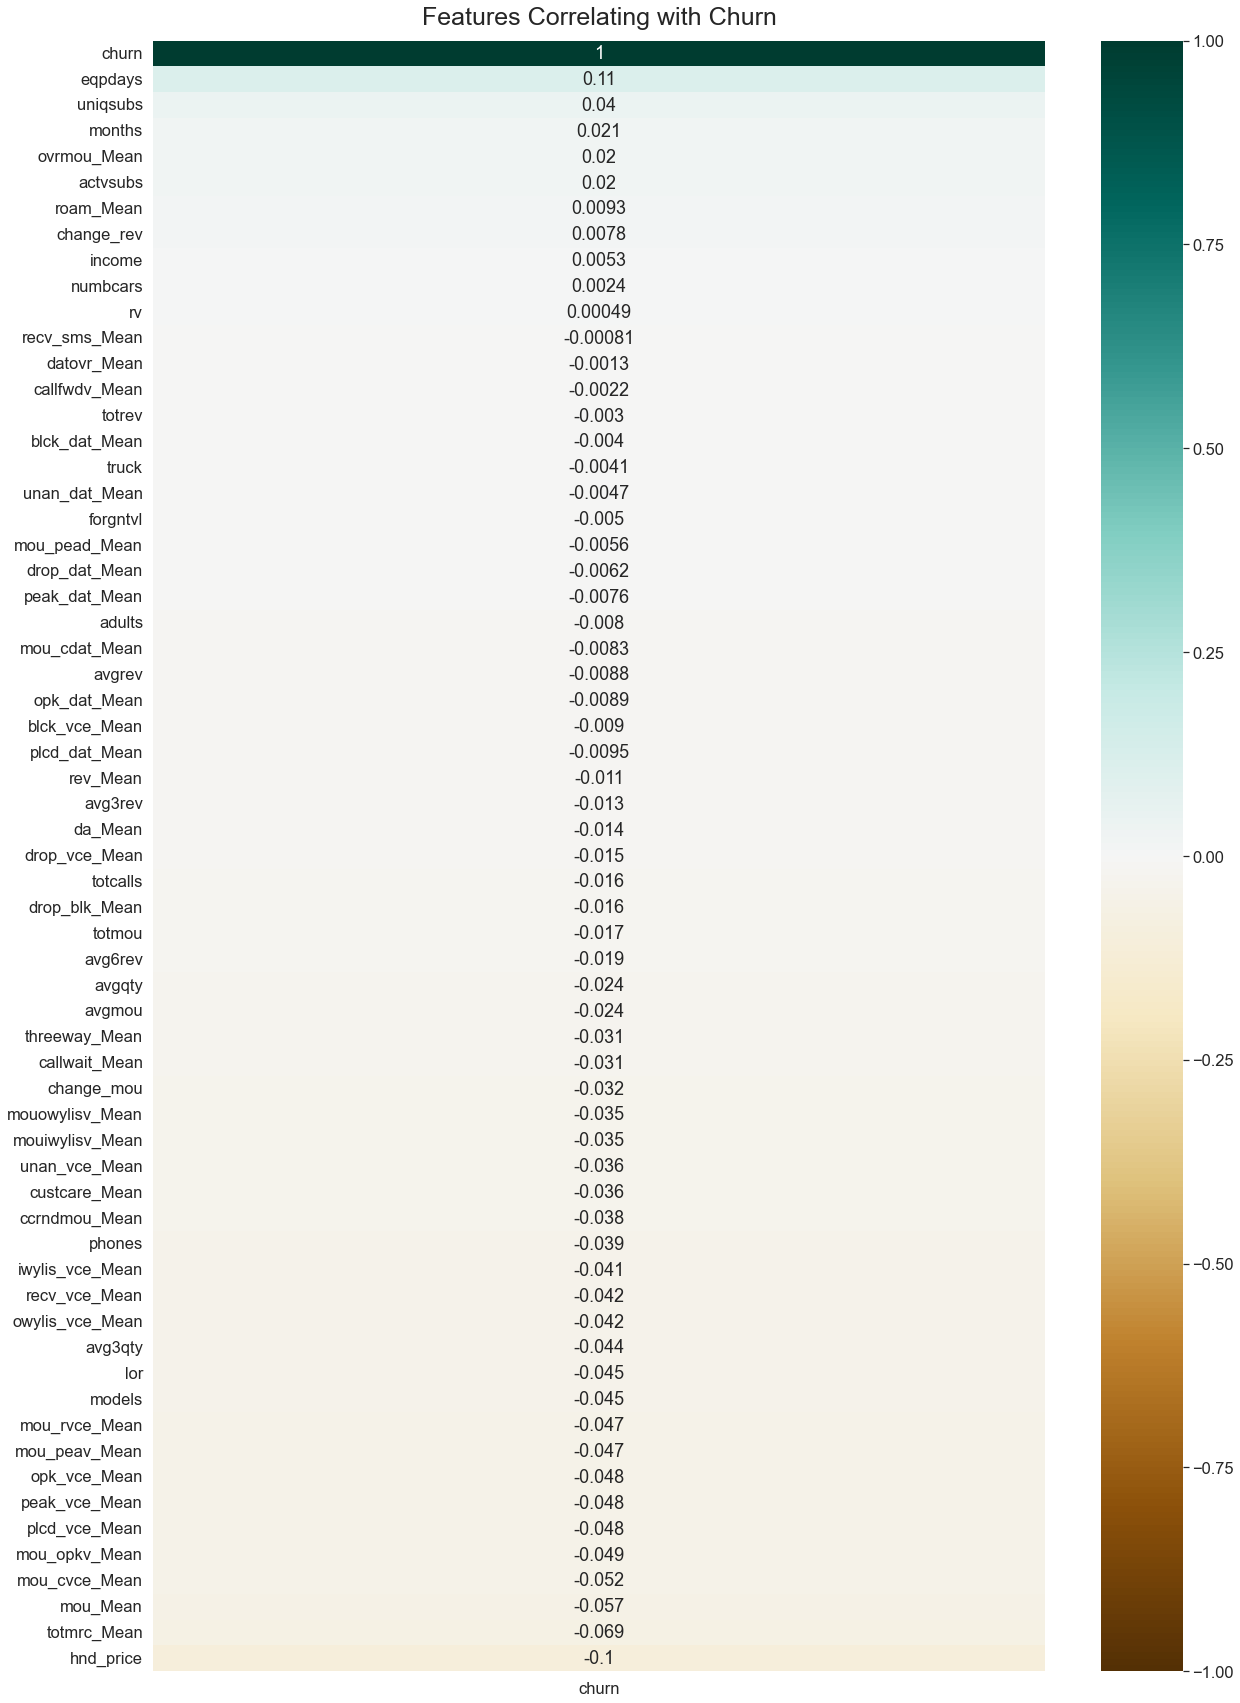

In [31]:
# look at numerical correlations of feature to target
sns.set(rc = {'figure.figsize':(20,30)})
sns.set(font_scale = 1.5)
heatmap = sns.heatmap(df.corr()[['churn']].sort_values(by='churn', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Churn', fontdict={'fontsize':25}, pad=16);

## Now replace all empty values in df with NaN and count

In [32]:
# fill any empty values with NaN
df = df.replace(' ', np.nan)
df.isna().sum().sum()

141177

In [33]:
# method to list features that contain 30% or more NaN's
def print_over(count):
    for index, val in count.iteritems():
        if val > 30000:
            print(index, val)

In [35]:
# Which numerical features have >30% NaN's?
c = df.columns
count_nan = df[c].isna().sum()
print_over(count_nan)

lor 30190
numbcars 49366


## Check for nulls and drop

In [37]:
df = df.dropna()

### Create Target and Training Data

In [38]:
target_name = "churn"
target = df[target_name]

data = df.drop(columns=[target_name])

### Build pipeline to encode, scale, and perform PCA demensionality reduction

In [39]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [40]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [41]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

In [42]:
pca =  PCA(n_components=.99)  

In [52]:
# Perform Linear Discrimenant Analysis

model = make_pipeline(preprocessor, pca, LinearDiscriminantAnalysis())

In [53]:
from sklearn import set_config
set_config(display='diagram')
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('pca', PCA(n_components=21)),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])

In [54]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

In [73]:
fitted = model.fit(data_train, target_train)

In [82]:
fitted.score(data_test, target_test)

0.6050535331905782